In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Conv2D,  Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import  DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# zip_file_path = r"C:\Users\rohit\Downloads\flickr30k_images-20250510T062639Z-001.zip"
# image_path = r"C:\Users\rohit\Downloads\flickr30k_images-20250510T062639Z-001\flickr30k_images"
image_path = '/content/drive/MyDrive/flickr30k_images'

# Unzip the file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(image_path)

# print("Unzip completed!")


In [ ]:

unzipped_dir = r"C:\Users\rohit\Downloads\flickr30k_images-20250510T062639Z-001"

for root, dirs, files in os.walk(unzipped_dir):
    for file in files:
        print(os.path.join(root, file))


In [ ]:
# captions_path = r"C:\Users\rohit\Downloads\flickr30k_images-20250510T062639Z-001\flickr30k_images\flickr30k_images\results.csv"
captions_path = '/content/drive/MyDrive/flickr30k_images/results.csv'
data = pd.read_csv(captions_path, sep='|')
data.columns = data.columns.str.strip()


In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

In [ ]:
image_path = '/content/drive/MyDrive/flickr30k_images\flickr30k_images'

data = pd.read_csv(captions_path, sep='|')
data.columns = ['image', 'comment_number', 'caption']
data['image'] = data['image'].str.strip()
data['caption'] = data['caption'].str.strip()
data = data[['image', 'caption']]


In [ ]:
import matplotlib.pyplot as plt
from textwrap import wrap
from PIL import Image
import os

def readImage(image_path):
    return Image.open(image_path)

def display_images(temp_df, base_path):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    for i in range(min(15, len(temp_df))):
        plt.subplot(5, 5, i + 1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image_file = os.path.join(base_path, temp_df.image[i])
        image = readImage(image_file)
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")


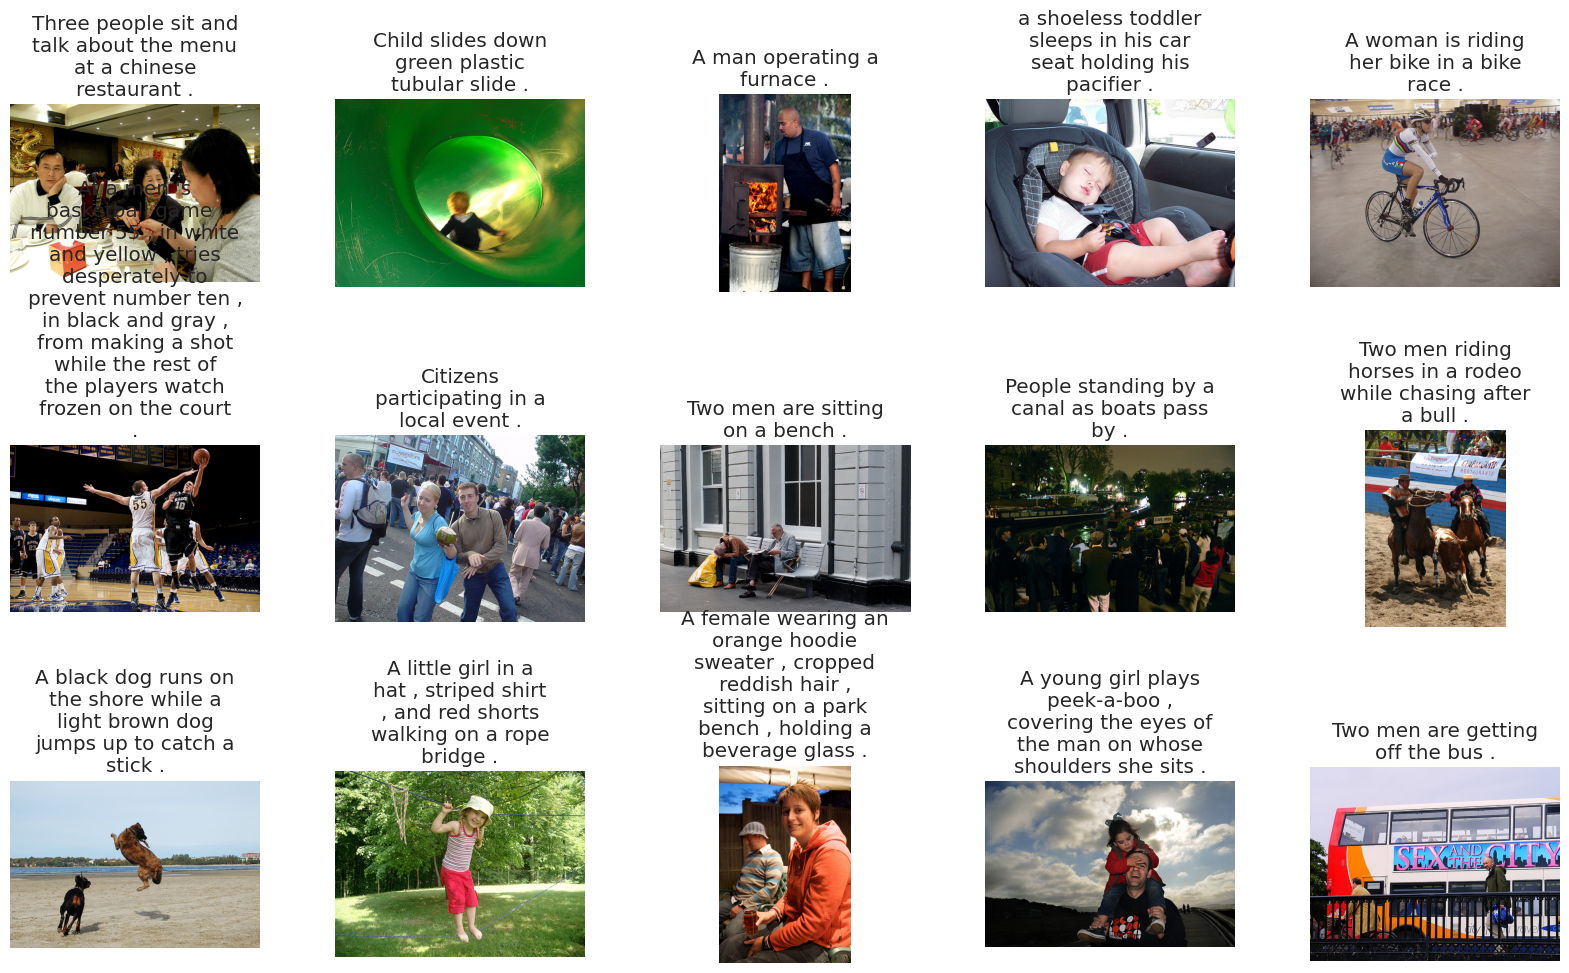

In [ ]:
image_folder = '/content/drive/MyDrive/flickr30k_images/flickr30k_images'
display_images(data.sample(15), image_folder)

In [ ]:
missing_images = []
for image_name in data.image:
    image_path = os.path.join(image_folder, image_name)
    if not os.path.exists(image_path):
        missing_images.append(image_name)

print(f"Missing images: {missing_images}")

Missing images: []


In [ ]:
def text_preprocessing(data):
    data = data.dropna(subset=['caption'])
    data['caption'] = data['caption'].astype(str).str.lower()
    data['caption'] = data['caption'].str.replace("[^A-Za-z]", " ", regex=True)
    data['caption'] = data['caption'].str.replace("\s+", " ", regex=True)
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    data['caption'] = "startsubseq " + data['caption'] + " endsubseq"
    return data


In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startsubseq two young guys with shaggy hair look at their hands while hanging out in the yard endsubseq',
 'startsubseq two young white males are outside near many bushes endsubseq',
 'startsubseq two men in green shirts are standing in yard endsubseq',
 'startsubseq man in blue shirt standing in garden endsubseq',
 'startsubseq two friends enjoy time spent together endsubseq',
 'startsubseq several men in hard hats are operating giant pulley system endsubseq',
 'startsubseq workers look down from up above on piece of equipment endsubseq',
 'startsubseq two men working on machine wearing hard hats endsubseq',
 'startsubseq four men on top of tall structure endsubseq',
 'startsubseq three men on large rig endsubseq']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

print(max_length)

74


In [ ]:
print(vocab_size)


18057


In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 31783/31783 [8:00:55<00:00,  1.10it/s]


In [ ]:
import pickle

features_path = '/content/drive/MyDrive/features_densenet201.pkl'

with open(features_path, 'rb') as f:
    features = pickle.load(f)

print("Features loaded successfully!")


Features loaded successfully!


In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [ ]:
import pickle
features_path = '/content/drive/MyDrive/features_densenet201.pkl'

with open(features_path, 'rb') as f:
    features = pickle.load(f)
print("Features loaded successfully!")
print(f"Number of features loaded: {len(features)}")

Features loaded successfully!
Number of features loaded: 31783


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Reshape, concatenate, add, RepeatVector, Flatten

input1 = Input(shape=(1920,))  # Image features
input2 = Input(shape=(max_length,))  # Text input (sequence of words)

# Dense layer for image features, reduced to match the expected size
img_features = Dense(128, activation='relu')(input1)  # Reduced number of units to match the reshape
img_features_reshaped = Reshape((1, 128))(img_features)  # Corresponding reshape to (1, 128)

# Flatten the reshaped image features to (None, 128)
img_features_flattened = Flatten()(img_features_reshaped)

# Repeat the flattened image features to match the length of the sentence
img_features_repeated = RepeatVector(max_length)(img_features_flattened)  # Repeat across the second axis (sequence length)

# Add a Dense layer to match the feature size (256) of the sentence features
img_features_repeated = Dense(256, activation='relu')(img_features_repeated)

# Embedding for the sentence input
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

# Concatenation of image features and sentence features (now shapes should match)
merged = concatenate([img_features_repeated, sentence_features], axis=2)  # Concatenate along the feature axis

# LSTM for processing the sequence after merging
sentence_features = LSTM(256)(merged)

# Dropout for regularization
x = Dropout(0.5)(sentence_features)

# Add a Dense layer to match the shape of img_features for skip connection
img_features_resized = Dense(256, activation='relu')(img_features)

# Skip connection with the resized image features
x = add([x, img_features_resized])

# Dense layer with dropout
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer with softmax for prediction
outputs = Dense(vocab_size, activation='softmax')(x)

# Define and compile the model
caption_model = Model(inputs=[input1, input2], outputs=outputs)
caption_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.utils import plot_model

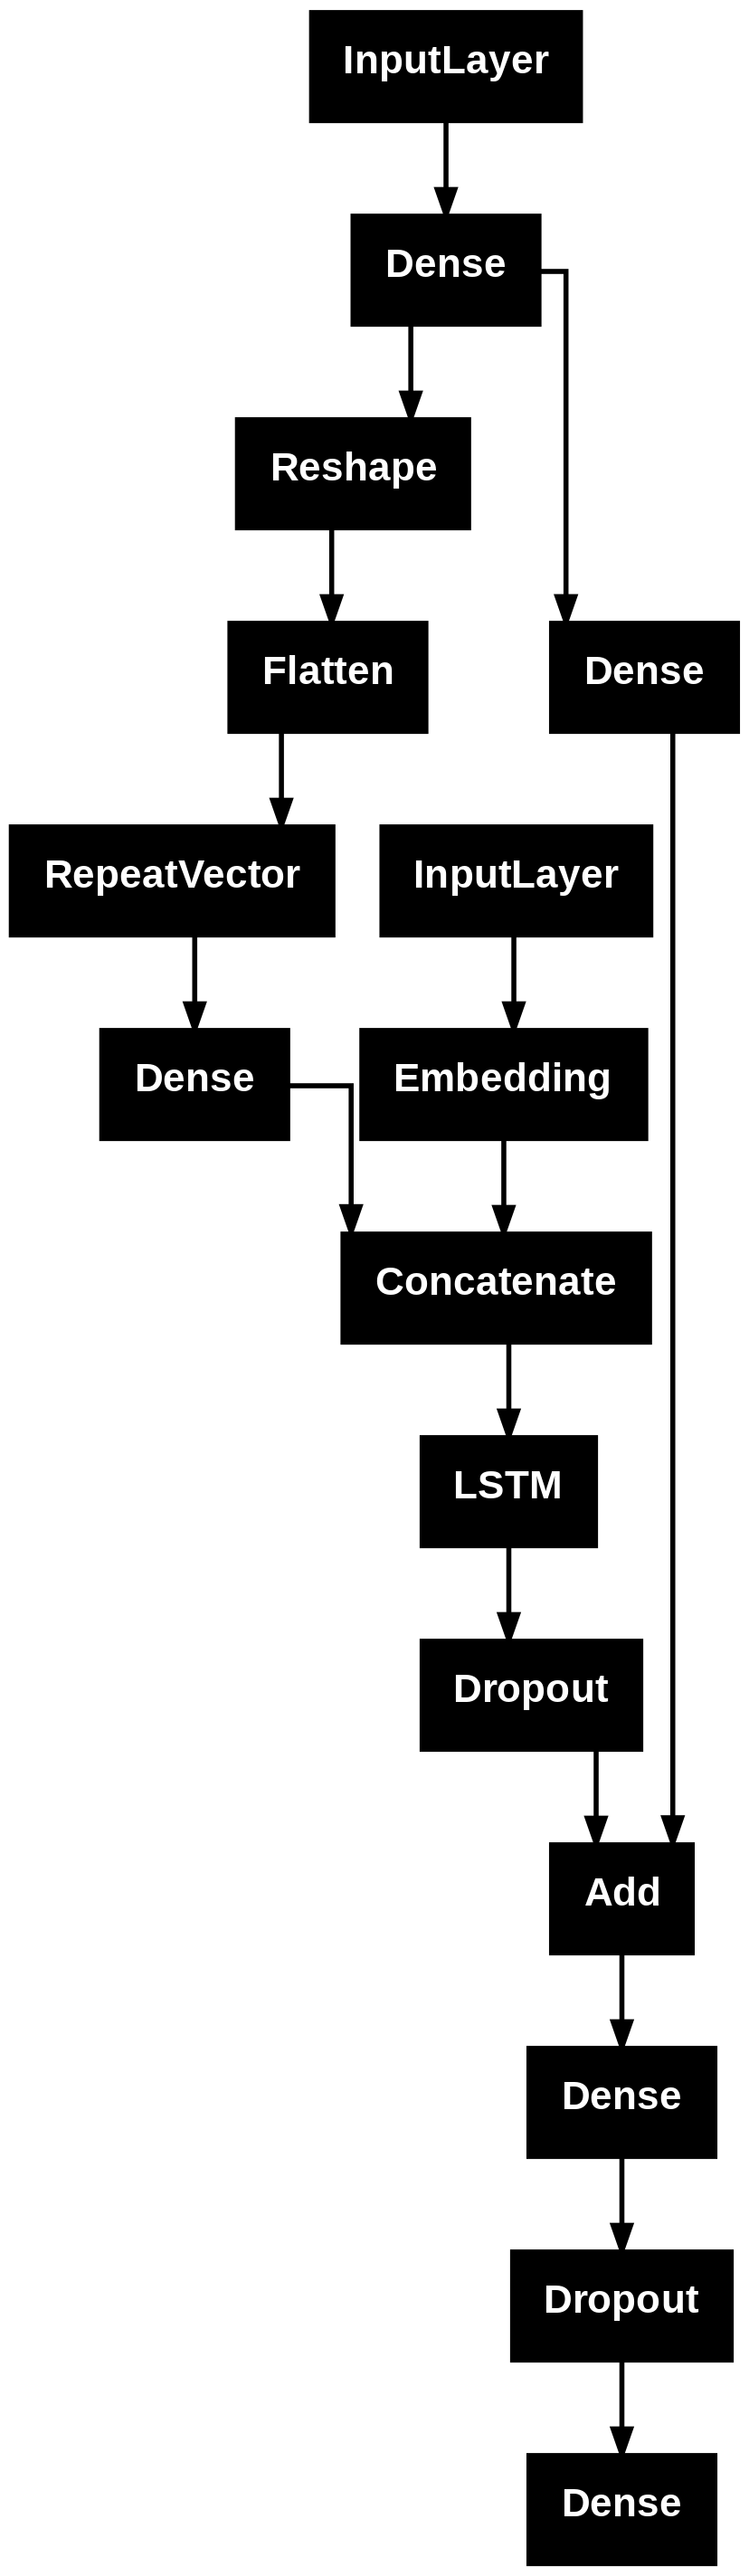

In [ ]:
plot_model(caption_model)


In [ ]:
caption_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 74)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 74, 256)   │  4,622,592 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 75, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 18057)     │  2,329,353 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,001,929 (30.52 MB)

 Trainable params: 8,001,929 (30.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 5.3783
Epoch 1: val_loss improved from inf to 4.51111, saving model to model.h5


2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3803s 2s/step - loss: 5.3781 - val_loss: 4.5111 - learning_rate: 0.0010
Epoch 2/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.3338
Epoch 2: val_loss improved from 4.51111 to 4.28075, saving model to model.h5


2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3893s 2s/step - loss: 4.3338 - val_loss: 4.2807 - learning_rate: 0.0010
Epoch 3/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.1145
Epoch 3: val_loss improved from 4.28075 to 4.18371, saving model to model.h5


2110/2110 ━━━━━━━━━━━━━━━━━━━━ 4023s 2s/step - loss: 4.1145 - val_loss: 4.1837 - learning_rate: 0.0010
Epoch 4/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.9956
Epoch 4: val_loss improved from 4.18371 to 4.12573, saving model to model.h5


2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3763s 2s/step - loss: 3.9956 - val_loss: 4.1257 - learning_rate: 0.0010
Epoch 5/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.9063
Epoch 5: val_loss improved from 4.12573 to 4.09879, saving model to model.h5


2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3726s 2s/step - loss: 3.9063 - val_loss: 4.0988 - learning_rate: 0.0010
Epoch 6/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.8540
Epoch 6: val_loss improved from 4.09879 to 4.08378, saving model to model.h5


2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3779s 2s/step - loss: 3.8540 - val_loss: 4.0838 - learning_rate: 0.0010
Epoch 7/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.8031
Epoch 7: val_loss improved from 4.08378 to 4.06833, saving model to model.h5


2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3771s 2s/step - loss: 3.8031 - val_loss: 4.0683 - learning_rate: 0.0010
Epoch 8/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.7650
Epoch 8: val_loss improved from 4.06833 to 4.06355, saving model to model.h5


2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3751s 2s/step - loss: 3.7651 - val_loss: 4.0635 - learning_rate: 0.0010
Epoch 9/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.7331
Epoch 9: val_loss did not improve from 4.06355
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3723s 2s/step - loss: 3.7331 - val_loss: 4.0659 - learning_rate: 0.0010
Epoch 10/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.7122
Epoch 10: val_loss did not improve from 4.06355
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3731s 2s/step - loss: 3.7122 - val_loss: 4.0720 - learning_rate: 0.0010
Epoch 11/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.6892
Epoch 11: val_loss did not improve from 4.06355

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3742s 2s/step - loss: 3.6892 - val_loss: 4.0700 - learning_rate: 0.0010
Epoch 12/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.6248
Epoch 12: val_loss did not improve from 4.06355
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3744s 2s/ste

2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3748s 2s/step - loss: 3.5973 - val_loss: 4.0608 - learning_rate: 2.0000e-04
Epoch 14/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.5892
Epoch 14: val_loss did not improve from 4.06077
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3716s 2s/step - loss: 3.5892 - val_loss: 4.0625 - learning_rate: 2.0000e-04
Epoch 15/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.5788
Epoch 15: val_loss did not improve from 4.06077
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3879s 2s/step - loss: 3.5788 - val_loss: 4.0761 - learning_rate: 2.0000e-04
Epoch 16/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.5668
Epoch 16: val_loss did not improve from 4.06077

Epoch 16: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 4004s 2s/step - loss: 3.5668 - val_loss: 4.0752 - learning_rate: 2.0000e-04
Epoch 17/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.5568
Epoch 17: val_loss did not improve from 4.06077
2110/2110 ━━━━━━━━━━━━━━━

In [ ]:
model.save('model.keras')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/model.keras')

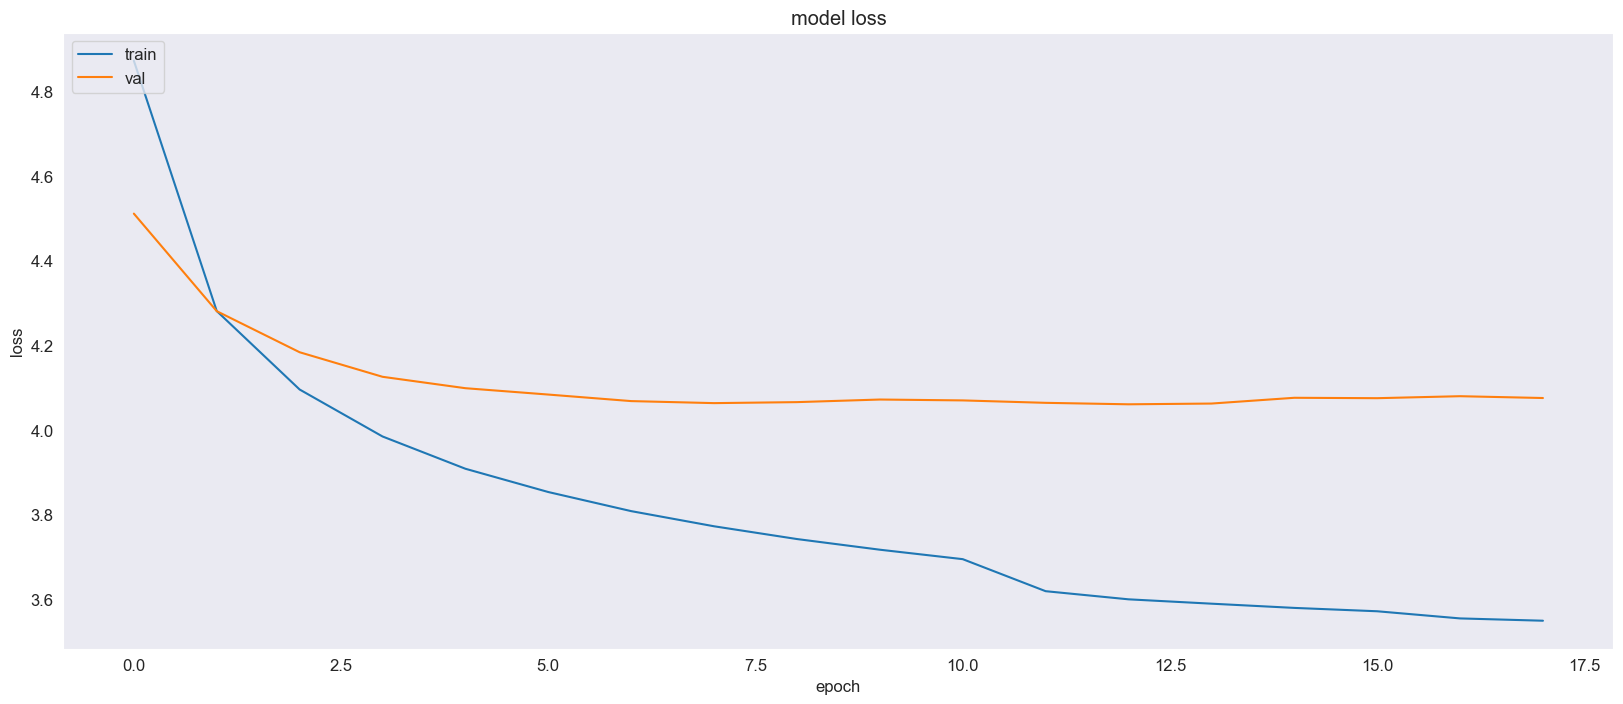

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index, record in samples.iterrows():
    try:
        img_path = os.path.join(image_path, record['image'])
        img = load_img(img_path, target_size=(224, 224))
        img = img_to_array(img)
        img = img / 255.

        caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
        samples.loc[index, 'caption'] = caption

    except Exception as e:
        print(f"Skipping {record['image']} due to error: {e}")
        continue


Skipping 6247027584.jpg due to error: [Errno 2] No such file or directory: '/content/drive/MyDrive/flicker_images/998845445.jpg/6247027584.jpg'
Skipping 6301591350.jpg due to error: [Errno 2] No such file or directory: '/content/drive/MyDrive/flicker_images/998845445.jpg/6301591350.jpg'
Skipping 916624251.jpg due to error: [Errno 2] No such file or directory: '/content/drive/MyDrive/flicker_images/998845445.jpg/916624251.jpg'
Skipping 5938205507.jpg due to error: [Errno 2] No such file or directory: '/content/drive/MyDrive/flicker_images/998845445.jpg/5938205507.jpg'
Skipping 8162775105.jpg due to error: [Errno 2] No such file or directory: '/content/drive/MyDrive/flicker_images/998845445.jpg/8162775105.jpg'
Skipping 7414768750.jpg due to error: [Errno 2] No such file or directory: '/content/drive/MyDrive/flicker_images/998845445.jpg/7414768750.jpg'
Skipping 6968629522.jpg due to error: [Errno 2] No such file or directory: '/content/drive/MyDrive/flicker_images/998845445.jpg/6968629522

In [ ]:
import os

image_folder = '/content/drive/MyDrive/flickr30k_images/flickr30k_images/'

all_images = [img for img in os.listdir(image_folder) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

print("Available images:", all_images)

selected_image_path = os.path.join(image_folder, all_images[0])
print("Selected image:", selected_image_path)


Available images: ['7863346994.jpg', '7810644900.jpg', '7796225106.jpg', '7773972760.jpg', '7788997944.jpg', '7808167068.jpg', '7784786374.jpg', '77587237.jpg', '7813154662.jpg', '7773568122.jpg', '7765548908.jpg', '7794723066.jpg', '7754834862.jpg', '7772746168.jpg', '7808530252.jpg', '7754646766.jpg', '783994497.jpg', '7832183018.jpg', '7806900624.jpg', '7760161706.jpg', '7847188372.jpg', '7808252542.jpg', '7787560818.jpg', '7849619682.jpg', '782680629.jpg', '77742716.jpg', '7847188568.jpg', '7814014742.jpg', '775664534.jpg', '7860117984.jpg', '7841142842.jpg', '7774468390.jpg', '7817889978.jpg', '7847188944.jpg', '782017931.jpg', '7831440908.jpg', '7752899970.jpg', '7787558364.jpg', '7777767632.jpg', '7760698166.jpg', '7760722986.jpg', '7782773136.jpg', '7806899062.jpg', '777288299.jpg', '7842242014.jpg', '7862746246.jpg', '7754829172.jpg', '7808046.jpg', '7804907374.jpg', '7822662028.jpg', '7827645972.jpg', '7851986978.jpg', '781387473.jpg', '78308597.jpg', '7803420092.jpg', '77568

In [ ]:

if 'startseq' not in tokenizer.word_index:
    tokenizer.word_index['startseq'] = len(tokenizer.word_index) + 1
if 'endseq' not in tokenizer.word_index:
    tokenizer.word_index['endseq'] = len(tokenizer.word_index) + 2

input_text = 'startseq cat endseq'
sequence = tokenizer.texts_to_sequences([input_text])[0]
print("Tokenized sequence:", sequence)


Tokenized sequence: [18057, 755, 18059]


Generated Caption: walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking walking an walking walking an walking


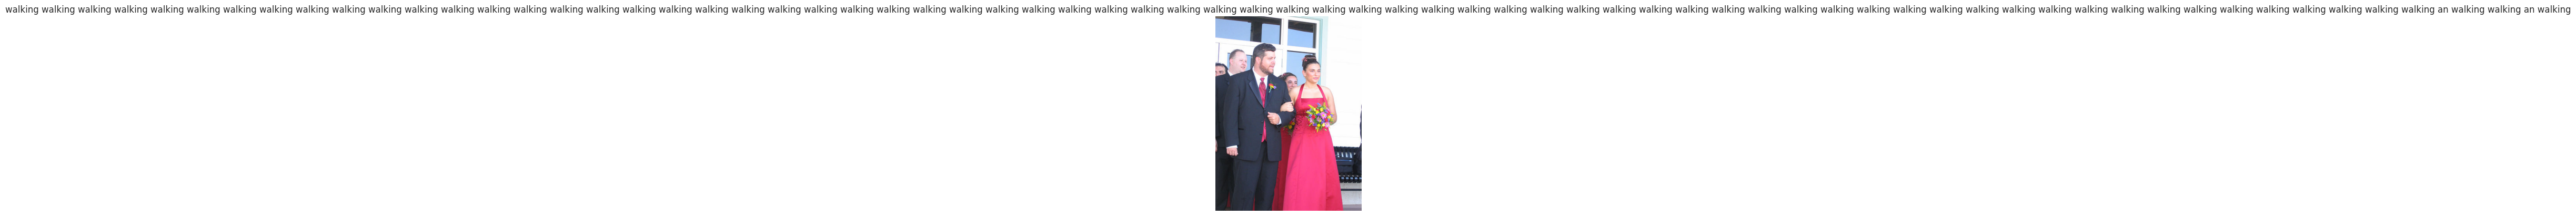

In [ ]:
def generate_caption(image_path, model, tokenizer, max_length):
    image_features = extract_features(image_path)

    if image_features.ndim == 3:
        image_features = image_features.reshape((image_features.shape[0], image_features.shape[2]))

    input_text = 'startsubseq'

    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        yhat = model.predict([image_features, sequence], verbose=0)
        yhat = yhat[0]

        predicted_word_index = np.argmax(yhat)
        predicted_word = tokenizer.index_word.get(predicted_word_index, '')

        if predicted_word == 'endsubseq' or predicted_word == '':
            break

        input_text += ' ' + predicted_word

    final_caption = input_text.replace('startsubseq', '').strip()

    return final_caption


image_path = image_path = '/content/drive/MyDrive/flickr30k_images/flickr30k_images/65567.jpg'
caption = generate_caption(image_path, model, tokenizer, max_length=74)
print("Generated Caption:", caption)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display the image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(caption, fontsize=12)
plt.show()
